# Event-based Attention (Camille et al, 2024)
This notebook contains an implementation of the event-based saliency algorithm by Camille et al. <br>
*Chane, C.S., Niebur, E., Benosman, R. and Ieng, S.H., 2024. An event-based implementation of saliency-based visual attention for rapid scene analysis. arXiv preprint arXiv:2401.05030.* <br>

Akwasi Akwaboah (July 08, 2024)

The saliency model

$$ S_{u,v}(x,y,t) = \Sigma_i{\frac{\mathbb{1}_\sigma (x_i, y_i, t_i)}{(1+2r_v)}}$$

$$\sigma = \{ e_i \bigg\vert |x-x_i| + |y-y_i| \leq r_u \text{ and } t-t_i\leq t_u\}$$

$$ \mathbb{1}_\sigma =  \begin{cases} 
1 & \text{if } (x_i, y_i, t_i) \in \sigma \geq 0, \\
0 & \text{otherwise }
\end{cases} $$

At Multiple spatial and temporal pyramidal scales

Space: $$r_v \in \{2^v\}_{0\leq v \leq \lambda}$$
Time: $$t_u \in \{10\times 2^u\}_{0\leq u \leq \tau}$$

Spatiotemporal Saliency:

$$ S_{ST} (x,y,t) = \frac{1}{ST_{max}}\sum_{u=0}^\tau \sum_{v=0}^\lambda S_{u,v}(x,y,t)$$


Load Test data

In [1]:
import numpy as np
# import multiprocessing as mp
import matplotlib.pyplot as plt
import event_stream
import matplotlib
import matplotlib.animation
import IPython.display
from utils import evSal

Load sample data

In [2]:
data_path = './data/babyfoot3_dvs_c.es'

#load data from online repository
# import urllib.request
# Download the sample data from Github (55 MB)
# data_path, _ = urllib.request.urlretrieve(
#     "https://github.com/neuromorphicsystems/tutorials/raw/main/data/stars.es",
#     "stars.es",
# )

decoder = event_stream.Decoder(data_path)
events = np.concatenate([chunk for chunk in decoder])
events = events.view(dtype=events.dtype.descr[:3] + [(('on', 'p'), '?')])
events['y'] = decoder.height - 1 - events['y']

Get some data insights

In [3]:
print('events start at', events['t'][0], 'and end at', events['t'][-1])
print('events count:', events.shape[0])
print('unique timestamps:', np.unique(events['t']).shape[0])

events start at 16000016 and end at 23999982
events count: 871422
unique timestamps: 761248


Instantiate the event-based spatiotemporal saliency object. Pass the number of temporal scales *tau* and the number of spatial scales *lmbda*

In [4]:
evSal_obj = evSal(height=decoder.width, width=decoder.height, tau=5, lmbda=5, events=events)

grouping events by time...
761248


Below, the code first determines the length of the event stream and picks three points, one in the middle and the other two midway points of the upper and interval half intervals. At these three point, a small time neighborhood, *2 x eps*, is searched for create the 3 saliency maps stored in *salMaps_case*. <br>

**Warning!!!:** You might need to grab a coffee while compute progresses depending on the number of events in the time intervals of interest and the number of temporal and spatial scales desired. A parallel implementation that will accelerate the process is being developed

In [5]:
ln = len(evSal_obj.timeKeys)
eps = 1000

starts = [(ln//4) - eps, (ln//2) - eps, (3*ln//4) - eps]
ends = [(ln//4) + eps, (ln//2) + eps, (3*ln//4) + eps]

salMaps_case = []

for i in range(len(starts)):
    print(f'Generating saliency maps for case {i+1}...')
    for j in range(starts[i], ends[i]):
        evSal_obj.computeSalMap(trig_event=events[j])
    evSal_obj.normalizeSalMap()
    salMaps_case.append(evSal_obj.salMapTop)
    evSal_obj.clearSalMap() #clear the saliency maps for the next case

Generating saliency maps for case 1...
Generating saliency maps for case 2...
Generating saliency maps for case 3...


Visualize saliency maps

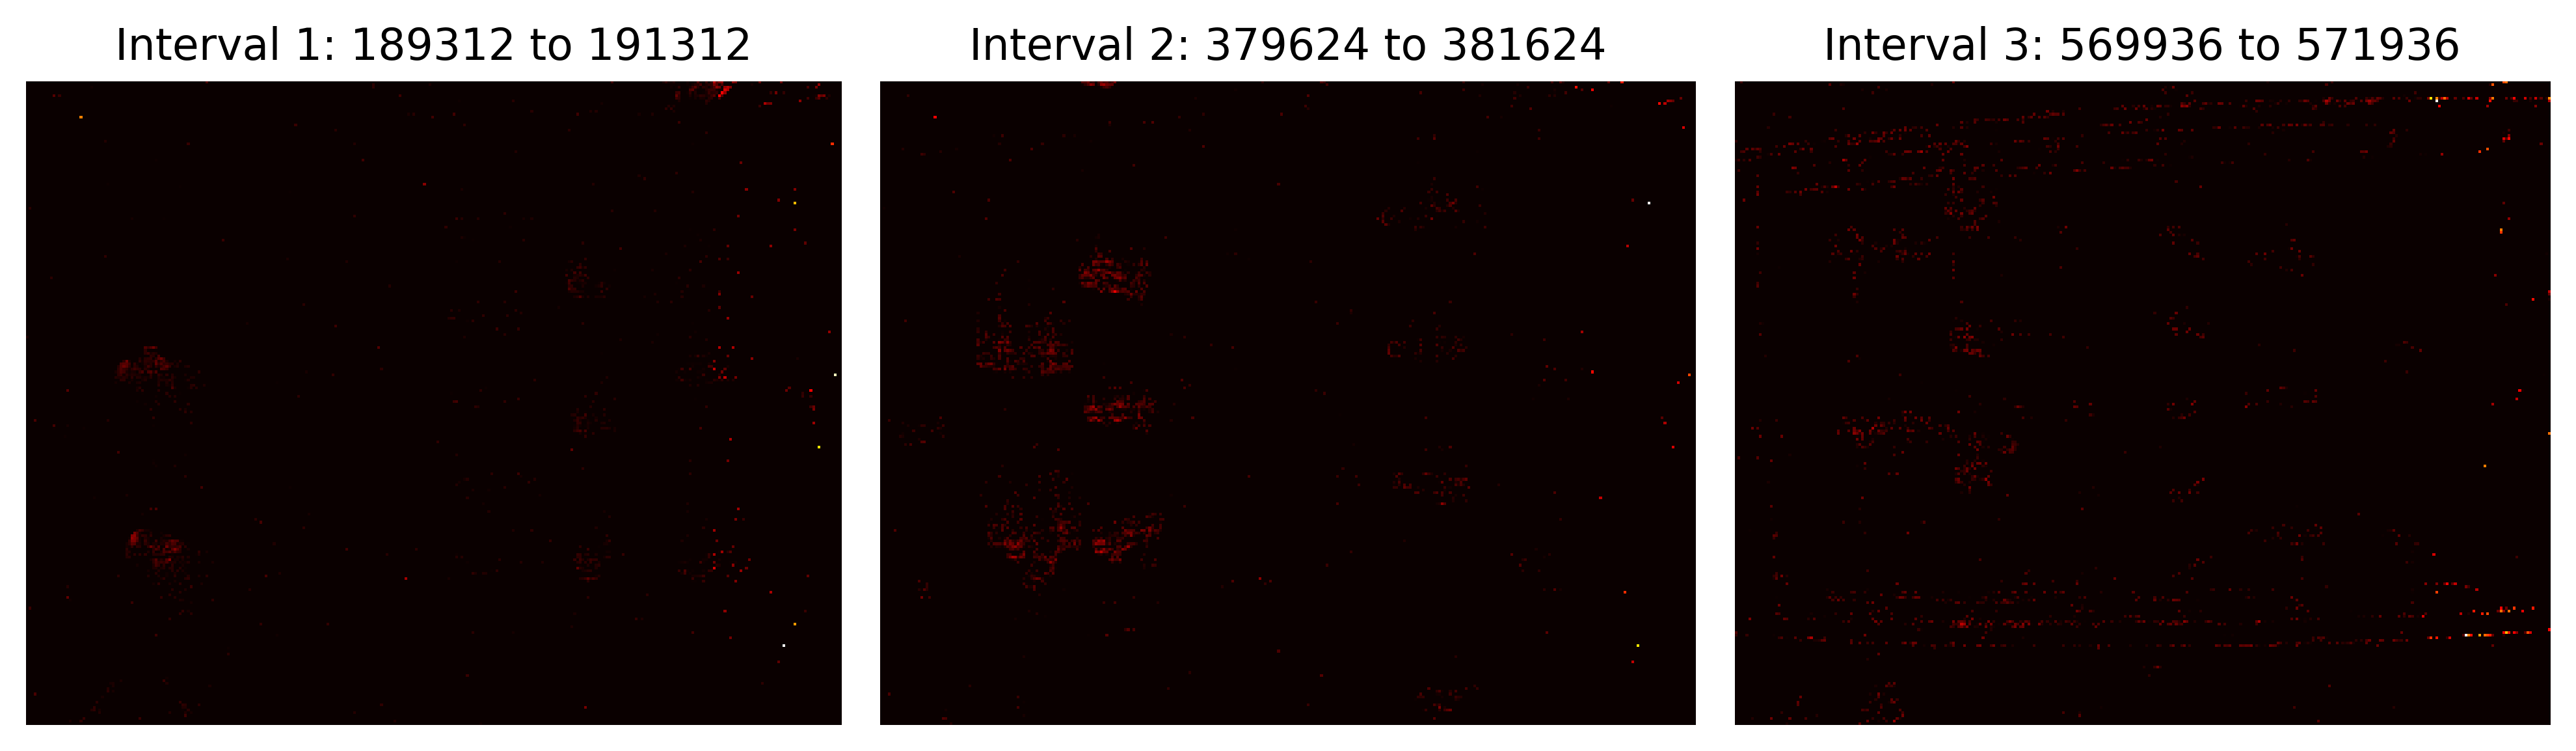

In [6]:
plt.figure(figsize=(10, 4), dpi=400)

for i in range(3):
    plt.subplot(131+i)
    plt.imshow(salMaps_case[i].T, cmap='hot', interpolation='nearest')
    plt.title(f'Interval {i+1}: {starts[i]} to {ends[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# plt.figure(figsize=(10, 4), dpi=400)
# plt.imshow(salMaps_case[1].T, cmap='hot', interpolation='nearest')
# plt.title(f'Interval {1+1}: {starts[1]} to {ends[1]}')
# plt.show()